In [1]:
import numpy as np
%matplotlib inline    
import mpld3
mpld3.enable_notebook()

In [2]:
import scipy.io
# loading of supervised data from matlab
dataFile = scipy.io.loadmat(r'E:\Ramu_Pittala\Physionet_2014\Data\FullTrainDataLabels_3typesD1_norm_var')
fullTrain = dataFile['fullTrain']
fullLabel = dataFile['fullLabel']
print('datasize is:',np.size(fullLabel))

datasize is: 478410


In [3]:
fullTrain.shape

(2, 241, 478410)

Label is:  0


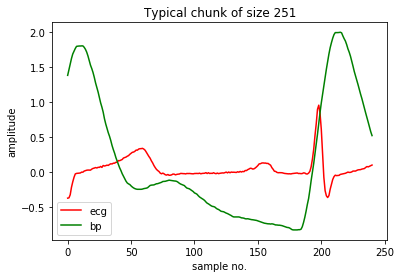

In [4]:
import matplotlib.pyplot as plt
# plot one sample of data
#fig = plt.figure(figsize = (8,5), dpi = 72)
plt.plot(fullTrain[0,:,123],'r')
plt.plot(fullTrain[1,:,123],'g')
print('Label is: ',fullLabel[0,123])
plt.xlabel('sample no.')
plt.ylabel('amplitude')
plt.title('Typical chunk of size 251')
plt.legend(['ecg','bp'])

In [5]:
fullTrain.shape, fullLabel.shape

((2, 241, 478410), (1, 478410))

In [20]:
fullTrain1 = fullTrain[:,:,0:1000]
fullLabel1 = fullLabel[0,0:1000]
# Reshaping data 
no_of_samples = np.shape(fullTrain1)[2]
dataSize = no_of_samples-3+1
trainData = np.zeros((dataSize,3,241,2,1),dtype = float)
trainLabels = np.zeros((dataSize,1), dtype = float)
for i in range(0,dataSize):
    for j in range(i,i+3):
        trainData[i,j-i,:,:,0] = fullTrain1[:,:,j].transpose()
        trainLabels[i,0] = fullLabel1[j]

In [216]:
fullTrain2 = fullTrain[:,:,1000:2000]
fullLabel2 = fullLabel[0,1000:2000]
# Reshaping data 
n = np.shape(fullTrain2)[2]
dS = n-3+1
testData = np.zeros((dS,3,241,2,1),dtype = float)
testLabels = np.zeros((dS,1), dtype = float)
lstm_output_size = 20
for i in range(0,dS):
    for j in range(i,i+3):
        testData[i,j-i,:,:,0] = fullTrain2[:,:,j].transpose()
        testLabels[i,0] = fullLabel2[j]

In [217]:
batchSize = 32
a1 = int(np.floor(len(trainLabels)/batchSize)) 
a2 = int(np.floor(len(testLabels)/batchSize)) + a1
numBatches = a2
total_length = batchSize*numBatches
list_IDs = np.arange(total_length)
labels = np.arange(total_length)

In [218]:
total_length


1984

In [232]:
np.shape(testData),np.shape(testLabels)

((998, 3, 241, 2, 1), (998, 1))

In [233]:
import keras

class DataGenerator(keras.utils.Sequence):
    
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(241,2), n_channels=1,
                 n_classes=2, shuffle=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(numBatches)

    def __getitem__(self, index):
        
        global data1,data2,label1,label2
        
        'Generate one batch of data'
        # Generate indexes of the batch
        print('index is:',index)
        index_start = index
        index_end = index + 1
        
        a0 = 0
        
        if(index_start == a0):
            # Data1 = scipy.loadmat('E:\Ramu_Pittala\Physionet_2014\Data\FullTrainDataLabels_3typesD1_norm_var_1_25')
            # fullTrain1 = Data1['fullTrain']
            # fullLabel1 = Data1['fullLabel']
            print('data1 loaded')
            data1 = trainData
            label1 = trainLabels
        elif(index_start == a1):
            # Data2 = scipy.loadmat('E:\Ramu_Pittala\Physionet_2014\Data\FullTrainDataLabels_3typesD1_norm_var_26_50')
            # fullTrain2 = Data2['fullTrain']
            # fullLabel2 = Data2['fullLabel']
            print('data2 loaded')
            data2 = testData
            label2 = testLabels

        # Generate data
        if(index_end<=a1):
            
            indexes = self.indexes[index_start*self.batch_size:(index_end)*self.batch_size]

            # Find list of IDs
            list_IDs_temp = [self.list_IDs[k] for k in indexes]
            print(list_IDs_temp)
            
            print("Trying to pass data")
            X, y = self.__data_generation(list_IDs_temp,data1,label1,index)
            
        elif(index_end<=a2 and index_end>a1):
            
            indexes = self.indexes[index_start*self.batch_size:(index_end)*self.batch_size]

            # Find list of IDs
            list_IDs_temp = [self.list_IDs[k-a1*self.batch_size] for k in indexes]
            print(list_IDs_temp)
            X, y = self.__data_generation(list_IDs_temp,data2,label2,index)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            print(1)
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp,data,label,index):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        # Initialization
        X = np.empty((self.batch_size,3, *self.dim, self.n_channels))
        
        #print('self dim is ',*self.dim)
        
        y = np.empty((self.batch_size), dtype=int)
        a0 = 0
        
        if(len(data)!=0):
            print('data has passed')
            
        # Generate data 
        if(index in range(a0,a1)):
            start = list_IDs_temp[0]
            i = start
            end = list_IDs_temp[self.batch_size-1]
            
            for i in range(start,end):   
                
                X[i%32,:,:,:,0] = data[i,:,:,:,0]
                y[i%32] = label[i]
                #i = i+1
                # print('i is:',i)
                
            print('index '+str(index)+'sequence passed')
            
        elif(index in range(a1,a2)):
            
            start = list_IDs_temp[0]
            i = start
            end = list_IDs_temp[self.batch_size-1]
           
            for i in range(start,end):  
            
                X[i%32,:,:,:,0] = data[i,:,:,:,0]
                y[i%32] = label[i]
                #i = i+1
            
            print('index '+str(index)+'sequence passed')

        return X, y

In [234]:
import numpy as np

from keras.models import Sequential
#from my_classes import DataGenerator
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten


from keras.layers.wrappers import TimeDistributed
from keras.layers import LSTM, Input
from keras.layers import Conv2D,ConvLSTM2D

# Parameters
params = {'dim': (241,2),
          'batch_size': 32,
          'n_classes': 2,
          'n_channels': 1}

# Datasets
#partition = # IDs
#labels = # Labels

# Generators
training_generator = DataGenerator(list_IDs, labels, **params)
#validation_generator = DataGenerator(partition['validation'], labels, **params)

# Design model
#model = Sequential()
inputs = Input(shape = (3,241,2,1),name = 'Input_layer')
#model.add(Embedding(max_features, embedding_size, input_length=maxlen))
#model.add(Dropout(0.25))
ConvOp = TimeDistributed(Conv2D(3, kernel_size=(72,2),activation='relu', input_shape=(241,2,1),data_format="channels_last"),name = 'Conv_layer')(inputs)
#model.add(Conv2D(3, kernel_size=(72,2),activation='relu', input_shape=(1,241,2),data_format="channels_first"))
FlatOp = TimeDistributed(Flatten(),name = 'Flatten_layer')(ConvOp)
#model.add(MaxPooling1D(pool_size=pool_size))
#model.add(Reshape((1,510), input_shape = (None, 510)))
lstm= LSTM(lstm_output_size, input_shape = (3,510), name = 'LSTM_layer')(FlatOp)
DensOp = Dense(1,name = 'Dense_layer')(lstm)
predictions = Activation('sigmoid',name = 'Output_layer')(DensOp)

model = Model(inputs=inputs, outputs=predictions)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [235]:
# Train model on dataset
print('Train...')
model.fit_generator(generator=training_generator,epochs = 2,verbose=2,shuffle = False)
print(model.summary())

Train...
Epoch 1/2
index is: 0
data1 loaded
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Trying to pass data
data has passed
index 0sequence passed
index is: 1
[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
Trying to pass data
data has passed
index 1sequence passed
index is: 2
[64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
Trying to pass data
data has passed
index 2sequence passed
index is: 3
[96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
Trying to pass data
data has passed
index 3sequence passed
index is: 4
[128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 15

index is: 38
[224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255]
data has passed
index 38sequence passed
index is: 39
[256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287]
data has passed
index 39sequence passed
index is: 40
[288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319]
data has passed
index 40sequence passed
index is: 41
[320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351]
data has passed
index 41sequence passed
index is: 42
[352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 

index is: 16
[512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543]
Trying to pass data
data has passed
index 16sequence passed
index is: 17
[544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575]
Trying to pass data
data has passed
index 17sequence passed
index is: 18
[576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607]
Trying to pass data
data has passed
index 18sequence passed
index is: 19
[608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639]
Trying to pass data
data has passed
index 19sequence passed
index is: 20
[640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 

index is: 56
[800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831]
data has passed
index 56sequence passed
index is: 57
[832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863]
data has passed
index 57sequence passed
index is: 58
[864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895]
data has passed
index 58sequence passed
index is: 59
[896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927]
data has passed
index 59sequence passed
index is: 60
[928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 

In [ ]:
'''print('Train...')
model.fit(trainData, trainLabels,
          batch_size=32,
          epochs=2
         )
print(model.summary())'''

In [ ]:
print(cell.shape)
model.evaluate(testData,testLabels)

In [ ]:
for layer in model.layers:
    config = layer.get_config()
    weights = layer.get_weights() # list of numpy arrays
    print(layer.name)
    print(config)
    print(weights)

In [ ]:
# Serialize model to json
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
# Serialize weights to HDF5
model.save_weights("E:\Ramu_Pittala\Downloads_R\ee18resch01004@iith.ac.in-405-entry\Model_CRNN1.h5")
print("Saved model to disk")

In [ ]:
a = model
Conv_Weights = a.layers[1].get_weights()
LSTM_Weights = a.layers[3].get_weights()
Dense_Weights = a.layers[4].get_weights()

In [ ]:
a.layers

In [ ]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights
loaded_model.load_weights('Model_CRNN.h5')
print('loaded model from disk')

In [ ]:
loaded_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
loaded_model.evaluate(testData,testLabels)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)